In [1]:
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

#Choose which nw:
nwChoice=700 #350 or 700

if nwChoice == 350:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
elif nwChoice == 700:
    fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs


" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    nwJunctions=nw['number_of_junctions'][0][0]
    print('Network '+str(nwSize)+ ' Loaded')
#     this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=3
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

    elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain,nwSize,nwJunctions





2022-04-13 12:12:50,606:INFO:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [2]:
import scipy.io as spio

def loadmatNew(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


In [3]:
connectivity,sources,drain_pool,nwSize,nwJunctions=buildNetworks(fileName,True,2,9)

Network 698 Loaded


In [4]:
numDT=1000
run_time=100
dt=0.01
stimulus=[]
stimulus.append(stimulus__(biasType='Drain',T=100))
signal=[1,1,1,0,0,0,0,0,0,0]
onAmp=0.3
signal = signal_expand(signal,numDT)*onAmp
for m in range(len(sources)): #create stimulus for each source electrode
    stimulus.append(stimulus__(biasType='Custom',T=100,dt=dt,customSignal=signal))
            

In [5]:
eles = np.append(drain_pool, sources)
sim=runSim(connectivity,stimulus=stimulus,junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = None,
                                   disable_tqdm=False,
                                   collapse=False,)

Running Simulation : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:17<00:00, 50.73it/s]


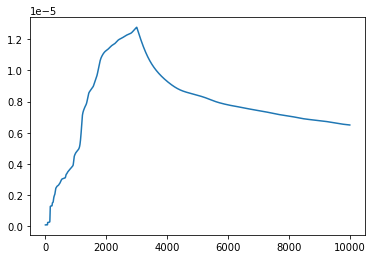

In [6]:
plt.figure()
plt.plot(np.mean(sim.junctionConductance,axis=1))

In [7]:
savemat(dataLoc+'simb0p5.mat',{'Simb0p5':sim})

In [8]:
simb5=loadmatNew(dataLoc+'simb5.mat')['Simb5']
simb2=loadmatNew(dataLoc+'simb2.mat')['Simb2']
simb0p5=loadmatNew(dataLoc+'simb0p5.mat')['Simb0p5']


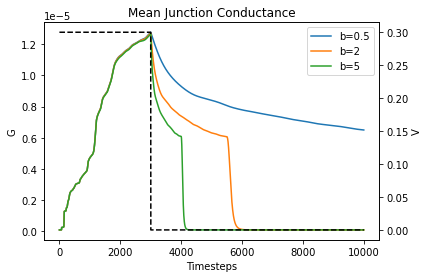

In [22]:
plt.rcParams['pdf.fonttype'] = 42

fig,ax=plt.subplots(1,1)

ax.plot(np.mean(simb0p5['junctionConductance'],axis=1),label='b=0.5')
ax.plot(np.mean(simb2['junctionConductance'],axis=1),label='b=2')
ax.plot(np.mean(simb5['junctionConductance'],axis=1),label='b=5')

plt.title('Mean Junction Conductance')
plt.xlabel('Timesteps')
plt.ylabel('G')
plt.legend()

ax2=ax.twinx()
ax2.plot(simb5['stimulus'][2].signal,'--',c='k')
ax2.set_ylabel('V')

plt.savefig(saveFig+'698nw_2545nj_avg_junction_conductance_onAmp0p3.pdf',format='pdf',dpi=100)

array([0.3, 0.3, 0.3, ..., 0. , 0. , 0. ])